In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import pandas as pd
import tqdm.notebook as tqdm
from multiprocessing import Pool
import seaborn as sns
import subprocess
import os
import pickle
import json 

import py.data_gen as data_gen
import py.algos as algos

plt.rcParams.update({'font.size': 18})

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
  
def save_runs(exp_root, exp_name, runs, args):
    git_hash = algos.get_git_revision_hash()
    dirty = b'script.py' in subprocess.check_output(['git', 'diff', '--name-only'])
    exp_root = os.path.join(exp_root, f'{git_hash}-dirty' if dirty else f'{git_hash}')
    exp_dir = os.path.join(exp_root, exp_name)
    os.makedirs(exp_dir)
    with open(os.path.join(exp_dir, 'results'), 'wb') as f:
        pickle.dump(runs, f)
    with open(os.path.join(exp_dir, 'args' ), 'w') as f:
        json.dump(vars(args), f, indent=True, sort_keys=True, cls=NumpyEncoder)

def get_accepted_per_round(_runs, n_rounds):
  _list1 = []
  for _r in _runs:
    accepted_per_round = np.array(np.array_split(_r, n_rounds)).sum(axis=-1)
    rejected_per_round = 1 - accepted_per_round
    _list1.append(accepted_per_round)
  accepted_per_round = np.concatenate(_list1)
  return accepted_per_round

## harris et. al setup with selection

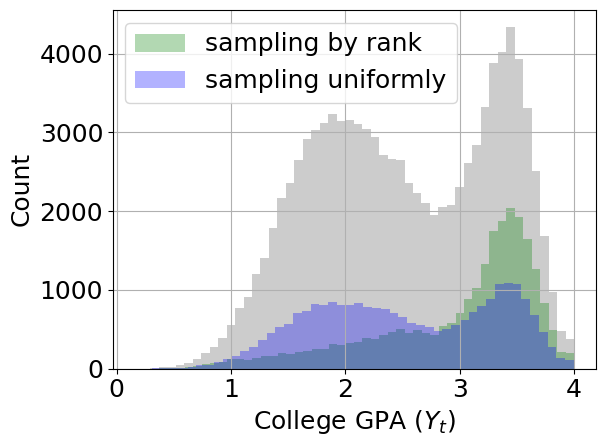

In [16]:
# plot data.
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --envs-accept-rates .25 --rank-type uniform'
args = algos.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --envs-accept-rates .25 --rank-type prediction'
args = algos.get_args(cmd)
np.random.seed(1)
b,x,y2,EW,theta, w, z2, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )
fig,ax=plt.subplots()
plt.hist(y2[0], alpha=.2 , color='k', bins=50)
plt.hist(y2[0][z2==1], color='g', bins=50, alpha=.3, label='sampling by rank')
plt.hist(y[0][z==1], color='b', bins=50, alpha=.3, label='sampling uniformly')
ax.grid()
ax.set_xlabel('College GPA ($Y_t$)')
ax.set_ylabel('Count')
ax.legend () 

# assert np.all (y2[0] ==y[0] )
plt.tight_layout()
plt.savefig('figures/haris-et-al-selection-dist.pdf')

In [17]:
n_runs = 50  
# ranking selection
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --methods ols 2sls --envs-accept-rate .25 --rank-type prediction'
args = algos.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(algos.run_multi_env, args_list )
runs = [r[0] for r in runs]

# uniform sampling
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --methods ols 2sls --envs-accept-rate .25 --rank-type uniform'
args = algos.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs2 = p.starmap(algos.run_multi_env, args_list )
runs2 = [r[0] for r in runs2]

99it [00:00, 121.44it/s]
99it [00:00, 125.92it/s]
99it [00:01, 90.52it/s]]
99it [00:01, 81.14it/s]]
99it [00:01, 86.93it/s]
99it [00:01, 81.09it/s]]
99it [00:01, 81.58it/s]]
99it [00:00, 105.36it/s]
99it [00:00, 105.85it/s]
99it [00:00, 141.43it/s]
99it [00:00, 180.56it/s]
99it [00:01, 84.66it/s] 
99it [00:01, 75.38it/s]]
99it [00:00, 170.32it/s]
99it [00:01, 76.44it/s]]
99it [00:01, 81.86it/s]
99it [00:00, 153.12it/s]
99it [00:00, 104.53it/s]
99it [00:00, 158.38it/s]
99it [00:00, 106.24it/s]
99it [00:00, 166.09it/s]
99it [00:00, 188.49it/s]
99it [00:00, 189.82it/s]
99it [00:00, 167.09it/s]
99it [00:00, 169.97it/s]
99it [00:00, 201.58it/s]
99it [00:00, 146.17it/s]
99it [00:00, 229.22it/s]
99it [00:00, 165.24it/s]
99it [00:00, 106.34it/s]
99it [00:00, 167.86it/s]
99it [00:00, 144.14it/s]
99it [00:00, 157.26it/s]
99it [00:00, 136.04it/s]
99it [00:00, 175.73it/s]
99it [00:00, 176.86it/s]
99it [00:00, 151.99it/s]
99it [00:01, 94.84it/s]
99it [00:00, 134.53it/s]
99it [00:00, 172.93it/s]
99i

In [18]:
df = algos.runs2df(runs)
df['sampling'] = 'sampling by rank'
df2 = algos.runs2df(runs2)
df2['sampling'] = 'sampling uniformly'
df = pd.concat((df, df2 ))

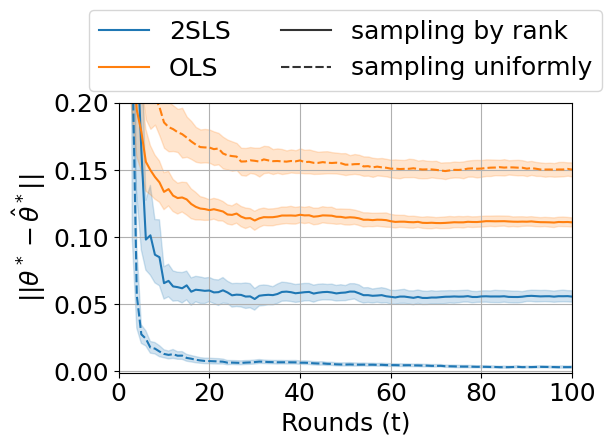

In [19]:
# converting to long format.
# df = script.runs2df(runs)
dflong = pd.melt(df, id_vars=('iterations', 'sampling'), value_vars=('ols_env0', '2sls_env0'), var_name='method', value_name='error')
dflong['method'] = dflong['method'].astype('category')
dflong['method']= dflong['method'].cat.rename_categories({'ols_env0':'OLS', '2sls_env0': '2SLS'})

dflong['iterations'] = dflong['iterations']+2
# plot
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='sampling', ax=ax)
ax.set_ylim(bottom=-0.001, top=0.2)
ax.legend(loc='upper right')
ax.set_ylabel(r'$||\theta^* - \hat{\theta}^*|| $')
ax.set_xlabel('Rounds (t)')
ax.grid()
ax.set_xlim((0, 100))
handles, labels = ax.get_legend_handles_labels()
handles =  [handles[1], handles[2], handles[4], handles[5]]
labels =  [labels[1], labels[2], labels[4], labels[5]]
ax.legend(handles=handles, labels=labels, ncol=2, loc='lower center', bbox_to_anchor=(0.25, 1, .5, .5))

plt.tight_layout()
plt.savefig('figures/harris-et-al-selection-results.pdf')

In [22]:
save_runs('experiments', 'harris-with-selection', (runs, runs2), args)

FileExistsError: [Errno 17] File exists: 'experiments/1059445/harris-with-selection'

## our setup.

In [20]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours --envs-accept-rate .5'

args = algos.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

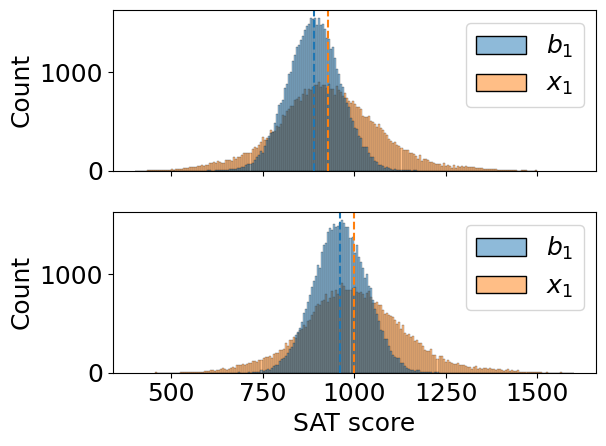

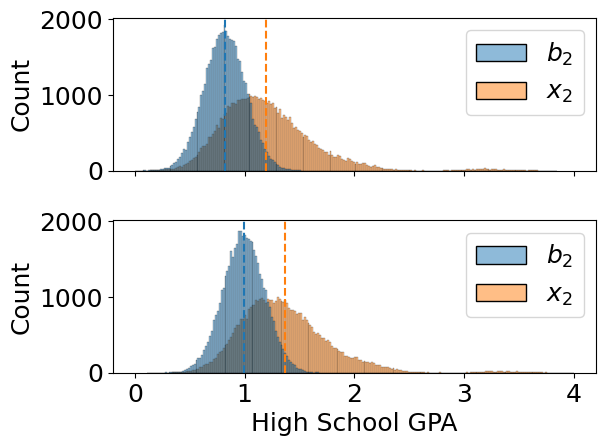

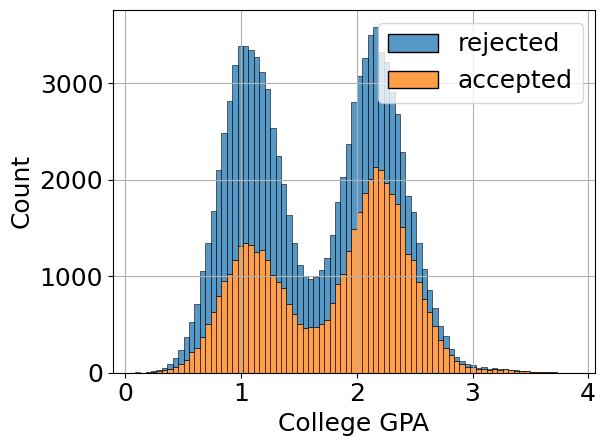

In [21]:
df0 = pd.DataFrame(
    {r'$b_1$': b[disadv_idx,0], r'$b_2$': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     r'$x_1$': x[disadv_idx,0], r'$x_2$': x[disadv_idx,1]},
)
df1 = pd.DataFrame(
    {r'$b_1$': b[adv_idx,0], r'$b_2$': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx], r'$x_1$': x[adv_idx, 0], r'$x_2$': x[adv_idx, 1], 'y_hat': y_hat[0, adv_idx]},
)
df0['class'] = 'disadv'
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df.status.astype('category').cat.rename_categories({0.0:'rejected', 1.0: 'accepted'})
df['status']

# SAT score
dflong = pd.melt(df, id_vars=('class'), value_vars=(r'$b_1$', r'$x_1$'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)

g = sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
g.legend_.set_title(None)
g = sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
g.legend_.set_title(None)
ax[1].set_xlabel('SAT score')

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$b_1$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$x_1$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$b_1$')].score.mean(), color=sns.color_palette()[0],  linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$x_1$')].score.mean(), color=sns.color_palette()[1],  linestyle='--')

plt.tight_layout()
plt.savefig('figures/our-settings-data1.png')

# GPA
dflong = pd.melt(df, id_vars=('class'), value_vars=(r'$b_2$', r'$x_2$'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
g = sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
g.legend_.set_title(None)
g = sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
g.legend_.set_title(None)
ax[1].set_xlabel('High School GPA')

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$b_2$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$x_2$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$b_2$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$x_2$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

plt.tight_layout()
plt.savefig('figures/our-settings-data2.png')

# dfa, dfr = pd.DataFrame({'y': y[0][z==1]}), pd.DataFrame({'y': y[0][z==0]})
# df = pd.concat((dfa, dfr))
fig,ax=plt.subplots()
g = sns.histplot(df, x='y', hue='status', ax=ax, multiple='stack')
g.legend_.set_title(None)
ax.set_xlabel('College GPA')
ax.grid()

plt.tight_layout()
plt.savefig('figures/our-settings-data3.pdf')

In [22]:
n_runs =50 
args = algos.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(algos.run_multi_env, args_list )
    _runs = [r[2] for r in runs]
runs = [r[0] for r in runs]

99it [00:09, 10.17it/s] 
99it [00:09,  4.33it/s]
99it [00:09, 10.31it/s]
99it [00:09,  9.90it/s]
99it [00:09, 10.07it/s]
99it [00:09, 10.19it/s]
99it [00:09, 10.35it/s]
99it [00:09, 10.37it/s]
99it [00:10,  9.39it/s]
99it [00:10,  9.29it/s]
99it [00:09,  9.91it/s]
99it [00:10,  9.88it/s]
99it [00:10,  9.89it/s]
99it [00:10,  9.89it/s]
99it [00:10,  9.43it/s]
99it [00:10,  9.45it/s]
99it [00:10,  9.31it/s]
99it [00:10,  9.56it/s]
99it [00:10,  9.38it/s]
99it [00:11,  8.83it/s]
99it [00:10,  9.22it/s]
99it [00:11,  8.93it/s]
99it [00:10,  9.36it/s]
99it [00:10,  9.19it/s]
99it [00:10,  9.13it/s]
99it [00:11,  8.53it/s]
99it [00:11,  8.71it/s]
99it [00:10,  9.12it/s]
99it [00:11,  8.75it/s]
99it [00:11,  8.42it/s]
99it [00:10,  9.15it/s]
99it [00:10,  9.53it/s]
99it [00:10,  9.40it/s]
99it [00:11,  8.68it/s]
99it [00:11,  8.68it/s]
99it [00:11,  8.32it/s]
99it [00:12,  8.23it/s]
99it [00:11,  8.59it/s]
99it [00:11,  8.37it/s]
99it [00:10,  9.44it/s]
99it [00:11,  8.82it/s]
99it [00:11,  8

In [23]:
df = algos.runs2df(runs)
# long format for plotting
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong 
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'ours': 'Ours', 'ols': 'OLS', '2sls': '2SLS'})
dflong
dflong_stack = dflong # remember for later. 
dflong_stack['iterations'] = dflong_stack['iterations']+2
dflong_stack 

,iterations,env,error,method
0,2,env0,0.075612,2SLS
1,3,env0,0.014819,2SLS
2,4,env0,0.005580,2SLS
3,5,env0,0.200922,2SLS
4,6,env0,0.199418,2SLS
...,...,...,...,...
14845,96,env0,0.012292,Ours
14846,97,env0,0.012619,Ours
14847,98,env0,0.012699,Ours
14848,99,env0,0.012699,Ours


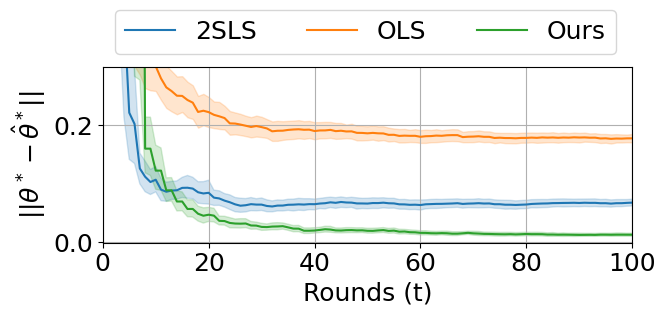

In [24]:
plt.rcParams.update({'font.size': 18})
fig,ax=plt.subplots(figsize=(7,3.5))
sns.lineplot(dflong_stack, x='iterations', y='error', errorbar=('ci', 95), ax=ax, hue='method',
             markers={'Ours': '^', 'OLS': 'X', '2SLS': 'o'}, markevery=10, markersize=9)
ax.grid()
ax.set_ylim(bottom=-0.001, top=.3)
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}^* || $')
ax.set_xlabel('Rounds (t)')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], ncol=3, loc='lower left', bbox_to_anchor=(0, 1, .5, .5))
ax.set_xlim((0, 100))
plt.tight_layout()
plt.savefig('figures/our-settings-single-env.pdf')

In [45]:
# save_runs('experiments', 'our-settings-single-env', runs, args)

In [25]:
## selection function variation. 
n_envs = 1
dfs = []
df_w = []
df_z = []
for env0_accept_rate in (.2, .4, .6, .8, 1.):
    cmd =f'--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours --offline-eval --envs-accept-rates {env0_accept_rate}'
    args = algos.get_args(cmd)

    n_runs = 10
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs_data = p.starmap(algos.run_multi_env, args_list )
    
    # recording errors
    runs = [r[0] for r in runs_data]
    df = algos.runs2df(runs)
    df['env0_accept_rate'] = env0_accept_rate
    dfs.append(df)
    
    # recording z
    runs_z = [r[2] for r in runs_data]
    accepted_per_round = get_accepted_per_round(runs_z, args.num_applicants / args.applicants_per_round)
    df = pd.DataFrame({'accepted_per_round': accepted_per_round, 'env0_accept_rate': env0_accept_rate})
    df['rejected_per_round'] = args.applicants_per_round - df['accepted_per_round']
    df_z.append(df)

df = pd.concat(dfs)
# df_w = pd.concat(df_w)
df_z = pd.concat(df_z)
value_vars = [f'{m}_env{ei}' for m in args.methods for ei in range(args.num_envs)]
value_vars
dflong = pd.melt(df, id_vars='env0_accept_rate', value_vars=value_vars, value_name='error', var_name='method_env')
dflong['method'] = dflong.method_env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.method_env.apply(lambda x:x.split('_')[-1])  


1it [00:03,  3.13s/it]
1it [00:03,  3.21s/it]
1it [00:03,  3.20s/it]
1it [00:03,  3.20s/it]
1it [00:03,  3.17s/it]
1it [00:03,  3.10s/it]
1it [00:03,  3.14s/it]
1it [00:03,  3.10s/it]
1it [00:03,  3.09s/it]
1it [00:03,  3.11s/it]
1it [00:04,  4.31s/it]
1it [00:04,  4.29s/it]
1it [00:04,  4.25s/it]
1it [00:04,  4.28s/it]
1it [00:04,  4.24s/it]
1it [00:04,  4.32s/it]
1it [00:04,  4.24s/it]
1it [00:04,  4.36s/it]
1it [00:04,  4.35s/it]
1it [00:04,  4.33s/it]
1it [00:05,  5.45s/it]
1it [00:05,  5.48s/it]
1it [00:05,  5.48s/it]
1it [00:05,  5.43s/it]
1it [00:05,  5.50s/it]
1it [00:05,  5.43s/it]
1it [00:05,  5.45s/it]
1it [00:05,  5.53s/it]
1it [00:05,  5.43s/it]
1it [00:05,  5.50s/it]
1it [00:06,  6.63s/it]
1it [00:06,  6.64s/it]
1it [00:06,  6.64s/it]
1it [00:06,  6.78s/it]
1it [00:06,  6.68s/it]
1it [00:06,  6.54s/it]
1it [00:06,  6.80s/it]
1it [00:06,  6.91s/it]
1it [00:06,  6.71s/it]
1it [00:06,  6.87s/it]
1it [00:07,  7.82s/it]
1it [00:07,  7.84s/it]
1it [00:07,  7.78s/it]
1it [00:07,

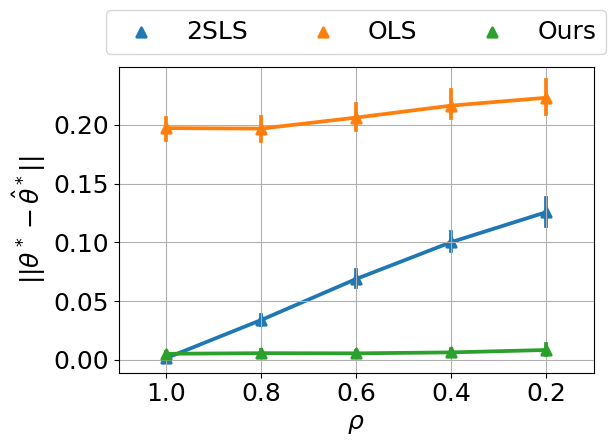

In [26]:
dflong
fig,ax=plt.subplots() 
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'2sls': '2SLS', 'ols': 'OLS', 'ours': 'Ours'})
sns.pointplot(data=dflong[dflong.env=='env0'], x='env0_accept_rate', y='error', hue='method', markers='^')
ax.grid() 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], ncol=3, loc='lower center', bbox_to_anchor=(0.5, 1))

ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}^*|| $')
plt.tight_layout()
ax.invert_xaxis () 
plt.savefig('figures/our-setttings-single-env-ablation.pdf')

In [49]:
# save_runs('experiments', 'our-settings-single-env-ablation', dflong, args)

## our setup (multiple envs.)

In [27]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs 2 --theta-star-std 0 --envs-accept-rate .5 .5 --num-cooperative-envs 2'
args = algos.get_args(cmd)
np.random.seed(3)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

1.6502210708204164
1.716850435185807
1.8170594956638126


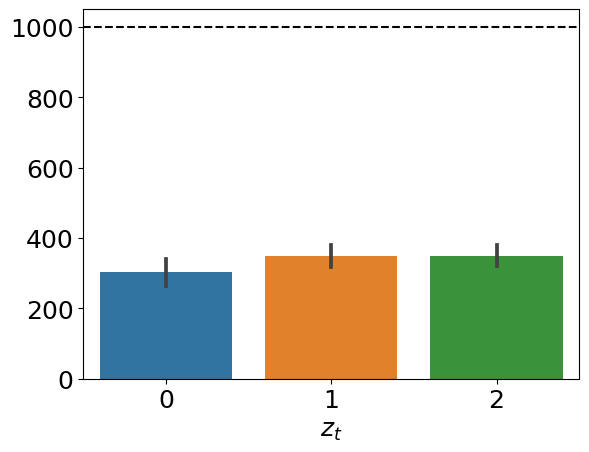

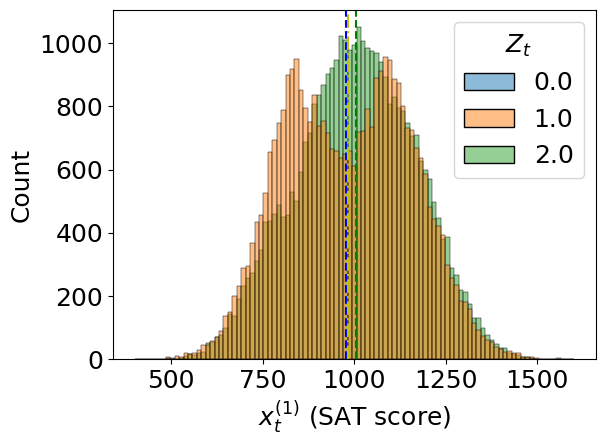

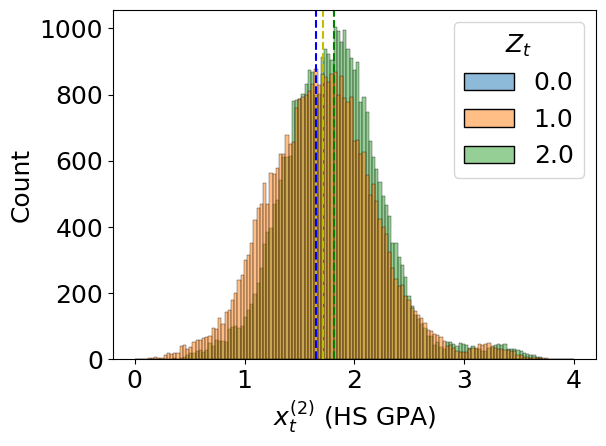

In [28]:

def add_envs(d, idx, var, prefix): 
    d.update({
        f'{prefix}_env{env_idx}': var[env_idx, idx] for env_idx in range(args.num_envs)
    })
    return d

# disadvantage class
df0 = {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]}
df0 = add_envs(df0, disadv_idx, y, 'y')
df0 = add_envs(df0, disadv_idx, w, 'w')
df0.keys() 

df0 = pd.DataFrame(df0)
df0['class'] = 'disadv'

# advantaged class
df1 = {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx],'y_hat': y_hat[0, adv_idx],
     'x1': x[adv_idx,0], 'x2': x[adv_idx,1]}
df1 = add_envs(df1, adv_idx, y, 'y')
df1 = add_envs(df1, adv_idx, w, 'w')
df1.keys() 

df1 = pd.DataFrame(df1)
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df['status'].astype('category')
df
fig,ax=plt.subplots()

# first plot
df_z = pd.get_dummies(df['status'] ).to_numpy()
df_z = np.array(
  np.split(
    df_z, (args.num_applicants / args.applicants_per_round),  axis=0 
  )
)
ax.axhline(y=args.applicants_per_round, color='k', linestyle='--')

assert df_z.shape == ((args.num_applicants / args.applicants_per_round), args.applicants_per_round, args.num_envs+1), f"{df_z.shape}"
df_z = df_z.sum(axis=1) 
sns.barplot(pd.DataFrame(df_z), ax=ax)
ax.set_xlabel(r'$z_t$')

# second plot
fig,ax=plt.subplots()
df = df.rename(columns={'status': r'$Z_t$'})
# df[r'$Z_t$'] = df[r'$Z_t$'].cat.rename_categories({0.0: '0', 1.0: '1', 2.0: '2'})

sns.histplot(df[df[r'$Z_t$']!=0], x='x1', hue=r'$Z_t$', ax=ax)
ax.axvline(x=df[df[r'$Z_t$']==0].x1.mean(), color='b', linestyle='--')
ax.axvline(x=df[df[r'$Z_t$']==1].x1.mean(), color='y', linestyle='-.')
ax.axvline(x=df[df[r'$Z_t$']==2].x1.mean(), color='g', linestyle='--')
ax.axvline(x=df[df[r'$Z_t$']==3].x1.mean(), color='r', linestyle='--')
ax.set_xlabel(r'$x_t^{(1)}$ (SAT score)')

plt.tight_layout()
plt.savefig('figures/our-settings-multi1.png')

# third plot
fig,ax=plt.subplots()
sns.histplot(df[df[r'$Z_t$']!=0], x='x2', hue=r'$Z_t$', ax=ax)
for env_idx, c  in zip(range(args.num_envs+1), ('b', 'y', 'g', 'r')):
  print(df[df[r'$Z_t$']==env_idx].x2.mean())
  ax.axvline(x=df[df[r'$Z_t$']==env_idx].x2.mean(), c=c, linestyle='--')

ax.set_xlabel(r'$x_t^{(2)}$ (HS GPA)')
plt.tight_layout() 
plt.savefig('figures/our-settings-multi2.png')

## protocol vs. no protocol.

In [29]:
_runs = []
for nce  in tqdm.tqdm((2, 1)):
    cmd = f'--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs 2 --theta-star-std 0 --envs-accept-rates .5 --num-cooperative-envs {nce}'
    # print(cmd)
    
    args = algos.get_args(cmd)
    n_runs = 50
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(algos.run_multi_env, args_list )
    _runs.append(runs)

  0%|          | 0/2 [00:00<?, ?it/s]


299it [02:23,  2.09it/s]
299it [02:23,  2.08it/s]
299it [02:23,  2.08it/s]
299it [02:23,  2.08it/s]
299it [02:23,  2.08it/s]
299it [02:24,  2.08it/s]
299it [02:23,  2.08it/s]
299it [02:23,  2.08it/s]
299it [02:24,  2.07it/s]
299it [02:23,  2.08it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.08it/s]
299it [02:23,  2.08it/s]
299it [02:24,  2.08it/s]
299it [02:24,  2.06it/s]
299it [02:25,  2.06it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.07it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
299it [02:24,  2.07it/s]
299it [02:24,  2.06it/s]
299it [02:24,  2.06it/s]
299it [02:24,  2.06it/s]
299it [02:25,  2.06it/s]
299it [02:25,  2.06it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.06it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
299it [02:25,  2.05it/s]
299it [02:26,  2.05it/s]
299it [02:26,  2.04it/s]
299it [02:26,  2.04it/s]

In [30]:
runs_protocol = _runs[0 ]
runs_no_protocol = _runs[1 ]

def get_data(runs_protocol, env_idx):
    dfs = []
    for r in runs_protocol:
        r = r[-1][f'ours_env{env_idx}']
        arr = np.array(r)
        dfs.append(pd.DataFrame(arr))
    df = pd.concat(dfs )
    df.reset_index(inplace=True);
    df.rename({'index': 'iterations'}, axis=1, inplace=True)
    df
    return df

dfs = []
for env_idx in (0, 1):
  df = get_data(runs_protocol, env_idx) 
  df2 = get_data(runs_no_protocol, env_idx)
  df['is-protocol'] = 'Co-op'
  df2['is-protocol'] = 'No co-op.'
  df = pd.concat((df, df2))
  df['env'] = env_idx
  dfs.append(df) 

df = pd.concat(dfs)
df.reset_index(inplace=True)
df 

,index,iterations,0,1,is-protocol,env
0,0,0,NaN,NaN,Co-op,0
1,1,1,NaN,NaN,Co-op,0
2,2,2,0.004170,0.000028,Co-op,0
3,3,3,0.004170,0.000028,Co-op,0
4,4,4,0.000645,0.518478,Co-op,0
...,...,...,...,...,...,...
59795,14945,294,-0.000141,0.488947,No co-op.,1
59796,14946,295,-0.000141,0.488947,No co-op.,1
59797,14947,296,-0.000141,0.488947,No co-op.,1
59798,14948,297,-0.000140,0.489031,No co-op.,1


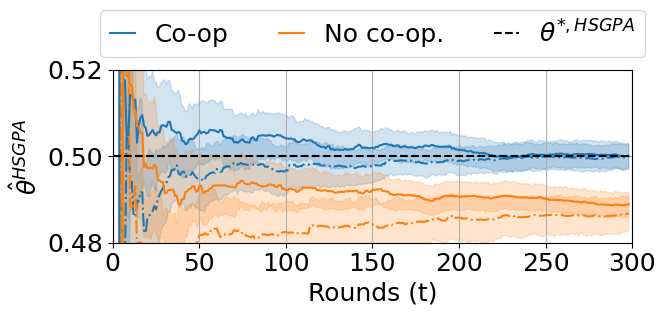

In [31]:
fig,ax=plt.subplots(figsize=(7,3.5))
sns.lineplot(df[df.env==1], x='iterations', y=1, hue='is-protocol', linestyle='dashdot', legend=False)
sns.lineplot(df[df.env==0], x='iterations', y=1, hue='is-protocol')
ax.set_ylim((0.48, 0.52))
ax.axhline(y=0.5, color='k', linestyle='--', label=r'$\theta^{*, HS GPA}$')
ax.set_ylabel(r'$\hat{\theta}^{HS GPA}$')
ax.set_xlabel(r'Rounds (t)')
ax.grid() 

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles=handles[:], labels=labels[:], ncol=3, loc='lower center', bbox_to_anchor=(0.5, 1), handlelength=1, labelspacing =0)

ax.set_xlim((0, 300))
plt.tight_layout()
plt.savefig('figures/protocol-vs-no-protocol.pdf')

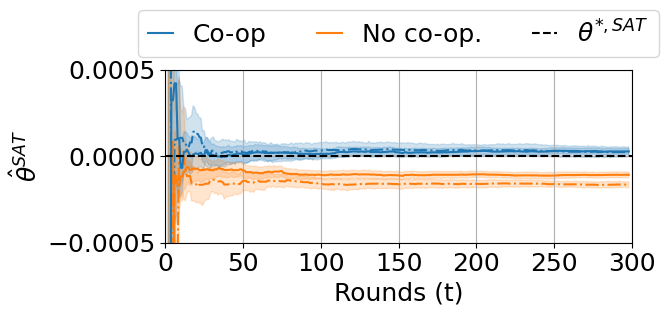

In [32]:
fig,ax=plt.subplots(figsize=(7,3.5))
sns.lineplot(df[df.env==1], x='iterations', y=0, hue='is-protocol', linestyle='dashdot', legend=False, errorbar=('ci', 99))
sns.lineplot(df[df.env==0], x='iterations', y=0, hue='is-protocol')
ax.set_ylim((-0.0005, 0.0005))
ax.axhline(y=0, color='k', linestyle='--', label=r'$\theta^{*, SAT}$')
ax.set_ylabel(r'$\hat{\theta}^{SAT}$')
ax.set_xlabel(r'Rounds (t)')
ax.grid() 

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles=handles[:], labels=labels[:], ncol=3, loc='lower center', bbox_to_anchor=(0.5, 1), handlelength=1, labelspacing =0)

ax.set_xlim((0, 300))
plt.tight_layout()
plt.savefig('figures/protocol-vs-no-protocol2.pdf')

In [33]:
_runs = []
n_envs = 3
coop_envs = (3, 2)
for nce  in tqdm.tqdm(coop_envs):
    cmd = f'--offline-eval --num-applicants 500000 --applicants-per-round 5000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs {n_envs} --theta-star-std .1 --envs-accept-rates .5 --num-cooperative-envs {nce}'
    # print(cmd)
    
    args = algos.get_args(cmd)
    n_runs = 100  
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(algos.run_multi_env, args_list )
        _runs.append(runs)

  0%|          | 0/2 [00:00<?, ?it/s]

1it [00:00,  1.13it/s]
1it [00:01,  1.09s/it]
1it [00:01,  1.38s/it]
1it [00:01,  1.36s/it]
1it [00:01,  1.10s/it]
1it [00:01,  1.11s/it]
1it [00:01,  1.75s/it]
1it [00:01,  1.27s/it]
1it [00:01,  1.54s/it]
1it [00:01,  1.53s/it]
1it [00:01,  1.86s/it]
1it [00:01,  1.31s/it]
1it [00:01,  1.80s/it]
1it [00:01,  1.95s/it]
1it [00:01,  1.66s/it]
1it [00:00,  1.32it/s]
1it [00:01,  1.51s/it]
1it [00:01,  1.44s/it]
1it [00:01,  1.30s/it]
1it [00:01,  1.14s/it]
1it [00:01,  1.35s/it]
1it [00:01,  1.06s/it]
1it [00:01,  1.05s/it]
1it [00:01,  1.88s/it]
1it [00:01,  1.61s/it]
1it [00:01,  1.47s/it]
1it [00:01,  1.58s/it]
1it [00:01,  1.70s/it]
1it [00:00,  1.00it/s]
1it [00:01,  1.10s/it]
1it [00:01,  1.43s/it]
1it [00:00,  1.07it/s]
1it [00:01,  1.45s/it]
1it [00:00,  1.05it/s]
1it [00:01,  1.29s/it]
1it [00:00,  1.00it/s]
1it [00:01,  1.50s/it]
1it [00:01,  1.20s/it]
1it [00:01,  1.42s/it]
1it [00:00,  1.04it/s]
1it [00:01,  1.01s/it]
1it [00:01,  1.05s/it]
1it [00:00,  1.12it/s]
1it [00:01,

In [34]:
dfs = []
for i, nce in enumerate((coop_envs)):
  df = algos.runs2df([r[0] for r in _runs[i]])
  df['cooperative envs.'] = r'Full Cooperation' if nce == 3 else r'Partial Cooperation'
  dfs.append(df)

df = pd.concat(dfs)
df['ours_env0+ours_env1'] = (df['ours_env0'] + df['ours_env1']) / 2.
df 

,iterations,ours_env0,ours_env1,ours_env2,cooperative envs.,ours_env0+ours_env1
0,0,0.003477,0.004488,0.006263,Full Cooperation,0.003982
1,0,0.012031,0.006962,0.000964,Full Cooperation,0.009497
2,0,0.013893,0.000433,0.001759,Full Cooperation,0.007163
3,0,0.004807,0.003717,0.007752,Full Cooperation,0.004262
4,0,0.001008,0.014227,0.003051,Full Cooperation,0.007618
...,...,...,...,...,...,...
95,0,0.002004,0.002251,0.007066,Partial Cooperation,0.002127
96,0,0.006560,0.010345,0.010648,Partial Cooperation,0.008452
97,0,0.014004,0.013472,0.020794,Partial Cooperation,0.013738
98,0,0.016225,0.016918,0.015263,Partial Cooperation,0.016571


In [35]:
value_vars= (f'ours_env{i}' for i in range(args.num_envs))
dflong = pd.melt(df, id_vars=('iterations', 'cooperative envs.'), value_vars=value_vars, var_name='env', value_name='error' )
dflong 

rename_cats_args = {f'ours_env{env_idx}': f'${env_idx+1}$' for env_idx in range(args.num_envs)}
dflong['env']=dflong.env.astype('category').cat.rename_categories(rename_cats_args)
dflong 

,iterations,cooperative envs.,env,error
0,0,Full Cooperation,$1$,0.003477
1,0,Full Cooperation,$1$,0.012031
2,0,Full Cooperation,$1$,0.013893
3,0,Full Cooperation,$1$,0.004807
4,0,Full Cooperation,$1$,0.001008
...,...,...,...,...
595,0,Partial Cooperation,$3$,0.007066
596,0,Partial Cooperation,$3$,0.010648
597,0,Partial Cooperation,$3$,0.020794
598,0,Partial Cooperation,$3$,0.015263


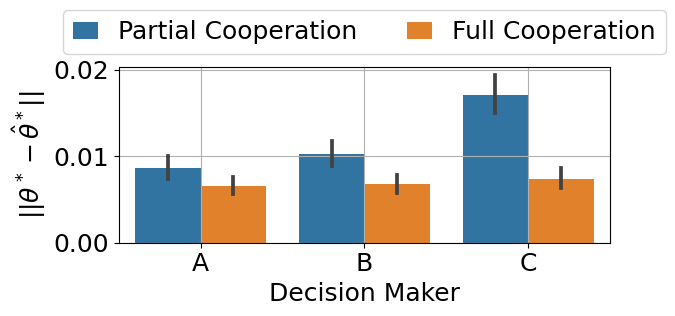

In [36]:
fig,ax=plt.subplots(figsize=(7,3.5))
sns.barplot(dflong, x='env', hue='cooperative envs.', y='error', 
            palette={'Full Cooperation': sns.color_palette()[1], 'Partial Cooperation': sns.color_palette()[0]},
            hue_order=('Partial Cooperation', 'Full Cooperation'))
# ax.legend(bbox_to_anchor=(1,1), title='cooperative envs.')
ax.grid() 
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}^*||$')
ax.set_xlabel('Decision Maker')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], ncol=2, loc='lower center', bbox_to_anchor=(0.5, 1), handlelength=1, labelspacing =0)
ax.set_xticklabels(('A', 'B', 'C'))

plt.tight_layout()
plt.savefig('figures/protocol-vs-no-protocol-group.pdf')

In [61]:
save_runs('experiments', 'protocol-vs-no-protocol-group', dflong, args)

# utility stuff clean

In [47]:
import numpy as np
from py.utils import recover_thetas
from py.data_gen import run_simulator, generate_data

# generate data. 
def run_multi_env_utility(args, seed, test_theta_envs):
    np.random.seed(seed)
    _, x, y, _, theta, _, z, _, _, _, _, theta_star, pref_vect = generate_data(
        args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, 
                  args, fixed_competitors=True)

    test_thetas = np.zeros(shape=(args.num_envs, 2))
    #  pt. 2: test theta of the first env.
    #  pt. 2.1. causal param estimate.
    err_list, est_list = {}, {}
    dictenv_err, dictenv_est = algos.run_single_env(
        args, x, y, theta, z, theta_star, 0, pref_vect
    )
    for k, v in dictenv_err.items():
        err_list[f'{k}_env0'] = v
    for k, v in dictenv_est.items():
        est_list[f'{k}_env0'] = v
    # pt. 2.2. test_theta of the first env. using causal estimate
    test_thetas[0] = recover_thetas(args.num_applicants, args.applicants_per_round, y, theta, z, 0, est_list, test_theta_envs[0])

    # pt. 3: test_theta for the rest of the envs. 
    for env_idx in range(1, args.num_envs):
        for k,v in dictenv_err.items():
            err_list[f'{k}_env{env_idx}'] = 0
            est_list[f'{k}_env{env_idx}'] = [theta_star[env_idx]] # using the ground truth theta star for fixed competitors.

        # recovering a test theta for the current environment.
        out = recover_thetas(args.num_applicants, args.applicants_per_round, y, theta, z, env_idx, est_list, test_theta_envs[env_idx])
        test_thetas[env_idx ] = out

    test_thetas = test_thetas[np.newaxis]

    # pt. 4. simulate again now using test_thetas 
    args.num_applicants = args.applicants_per_round # only one round.
    _, _, _, _, _, y_test,_, _ ,z_test,_, _ = run_simulator(
        args.applicants_per_round, args.fixed_effort_conversion, args, theta_star, test_thetas
        )
    y_test = y_test.T

    # pt. 5. compute utilities 
    utilities = np.zeros((args.num_envs,))
    for env_idx in range(args.num_envs):
        utilities[env_idx] = y_test[:,  env_idx][z_test==(env_idx+1)].mean()
    return utilities

cmd = ('--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence '
        '--fixed-effort-conversion --normalize --methods ours --envs-accept-rate .25 --num-envs 1' )
args = algos.get_args(cmd)
seed = 1
test_theta_envs = ('theta_ao_hat', ) * args.num_envs

1it [00:00,  3.38it/s]
1it [00:00,  2.48it/s]
1it [00:00,  2.15it/s]
1it [00:00,  2.03it/s]
1it [00:00,  2.10it/s]
1it [00:00,  2.65it/s]
1it [00:00,  1.39it/s]
1it [00:00,  1.18it/s]
1it [00:00,  1.60it/s]
1it [00:00,  2.07it/s]
1it [00:00,  1.39it/s]
1it [00:00,  1.72it/s]
1it [00:00,  2.91it/s]
1it [00:00,  1.33it/s]
1it [00:00,  1.02it/s]
1it [00:00,  1.21it/s]
1it [00:00,  1.74it/s]
1it [00:00,  1.99it/s]
1it [00:00,  1.07it/s]
1it [00:00,  1.51it/s]
1it [00:00,  1.33it/s]
1it [00:00,  1.19it/s]
1it [00:00,  1.20it/s]
1it [00:00,  1.09it/s]
1it [00:00,  1.88it/s]
1it [00:00,  1.29it/s]
1it [00:01,  1.32s/it]
1it [00:00,  1.31it/s]
1it [00:00,  1.60it/s]
1it [00:00,  1.77it/s]
1it [00:00,  1.60it/s]
1it [00:00,  1.40it/s]
1it [00:00,  1.12it/s]
1it [00:00,  1.11it/s]
1it [00:00,  1.47it/s]
1it [00:00,  3.06it/s]
1it [00:00,  1.10it/s]
1it [00:00,  1.54it/s]
1it [00:01,  1.20s/it]
1it [00:00,  2.06it/s]
1it [00:00,  1.03it/s]
1it [00:00,  1.10it/s]
1it [00:00,  2.55it/s]
1it [00:00,

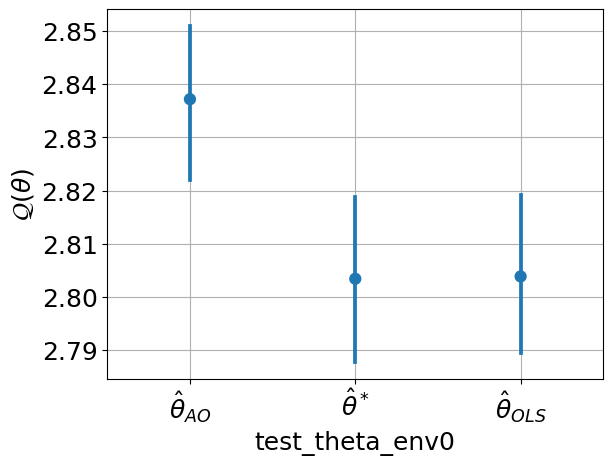

In [39]:
cmd =(f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence '
       '--fixed-effort-conversion --normalize --methods 2sls ols ours --envs-accept-rate .25')
cmd = f'{cmd} --offline-eval'

args = algos.get_args(cmd)
# one environment.
combos = [
    ('theta_ao_hat', ),
    ('theta_star_hat', ),
    ('theta_ols_hat', )
]

dfs = []
for combo in combos:
    n_runs = 100
    args_list = [(args, t, combo) for t in range(n_runs)]
    with Pool(n_runs) as p:
        results = p.starmap(run_multi_env_utility, args_list)

    results = np.array(results)
    pd_dict = {f'perf_env{env_idx}': results[:, env_idx] for env_idx in range(args.num_envs)}
    pd_dict.update(
        {f'test_theta_env{env_idx}': combo[env_idx] for env_idx in range(args.num_envs) }
    )
    df = pd.DataFrame(data=pd_dict)
    dfs.append(df )

df = pd.concat(dfs)
fig,ax=plt.subplots()
sns.pointplot(df, y='perf_env0', x='test_theta_env0', join=False)
ax.set_ylabel(r'$\mathcal{Q}(\theta)$')
ax.set_xticklabels(labels=[r'$\hat{\theta}_{AO}$', r'$\hat{\theta}^*$', r'$\hat{\theta}_{OLS}$'])
ax.grid() 

In [40]:
df_test = df.groupby('test_theta_env0').agg(('mean', 'sem'))
df_test 

perf_env0          
                     mean       sem
test_theta_env0                    
theta_ao_hat     2.837195  0.007925
theta_ols_hat    2.803878  0.008008
theta_star_hat   2.803440  0.008006

In [28]:
# with open('temp.pkl', 'wb') as f:
    # pickle.dump(df_test, f )
with open('temp.pkl', 'rb') as f:
    ref = pickle.load(f)
ref == df_test 

perf_env0      
                     mean   sem
test_theta_env0                
theta_ao_hat         True  True
theta_ols_hat        True  True
theta_star_hat       True  True

In [29]:
from itertools import  product
combos = [x for x in product(
    ('theta_ao_hat', 'theta_ols_hat', 'theta_star_hat'),
    ('theta_ols_hat', 'theta_ols_hat', 'theta_star_hat'),
)]
cmd = ('--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence '
       '--fixed-effort-conversion --normalize --methods ours ols --num-envs 2 --theta-star-std 0 '
       '--envs-accept-rates .5 --num-cooperative-envs 2')
cmd = f'{cmd} --offline-eval'
args =algos.get_args(cmd)

combos = [x for x in product(
    ('theta_ao_hat', 'theta_ols_hat', 'theta_star_hat'),
    ('theta_ao_hat', 'theta_ols_hat', 'theta_star_hat'),
)]

dfs = []
for combo in tqdm.tqdm(combos):
    n_runs = 100 
    args_list = [(args, t, combo) for t in range(n_runs)]
    with Pool(n_runs) as p:
        results = p.starmap(run_multi_env_utility, args_list)

    results = np.array(results)
    pd_dict = {f'perf_env{env_idx}': results[:, env_idx] for env_idx in range(args.num_envs)}
    pd_dict.update(
        {f'test_theta_env{env_idx}': combo[env_idx] for env_idx in range(args.num_envs) }
    )
    df = pd.DataFrame(data=pd_dict)
    dfs.append(df )

df = pd.concat(dfs)

[('theta_ao_hat', 'theta_ols_hat'),
 ('theta_ao_hat', 'theta_ols_hat'),
 ('theta_ao_hat', 'theta_star_hat'),
 ('theta_ols_hat', 'theta_ols_hat'),
 ('theta_ols_hat', 'theta_ols_hat'),
 ('theta_ols_hat', 'theta_star_hat'),
 ('theta_star_hat', 'theta_ols_hat'),
 ('theta_star_hat', 'theta_ols_hat'),
 ('theta_star_hat', 'theta_star_hat')]

In [42]:
df['test_theta_env0'] = df['test_theta_env0'].astype('category')
df['test_theta_env1'] = df['test_theta_env1'].astype('category')
pd.melt(df, id_vars='perf_env0', value_vars=('test_theta_env0', 'test_theta_env1'))
df 
df_ = df[['perf_env0', 'test_theta_env0', 'test_theta_env1']]

df_['test_theta_env1'] = df_['test_theta_env1'].cat.rename_categories(
    {
        'theta_ao_hat': r'$\hat{\theta}^{AO}_2$',
        'theta_star_hat': r'$\hat{\theta}^*_2$',
        'theta_ols_hat': r'$\hat{\theta}_{OLS}$'
        }
)
df_ = df_.rename(columns={'test_theta_env1': r'$\theta_{2t}$'})
df_ 


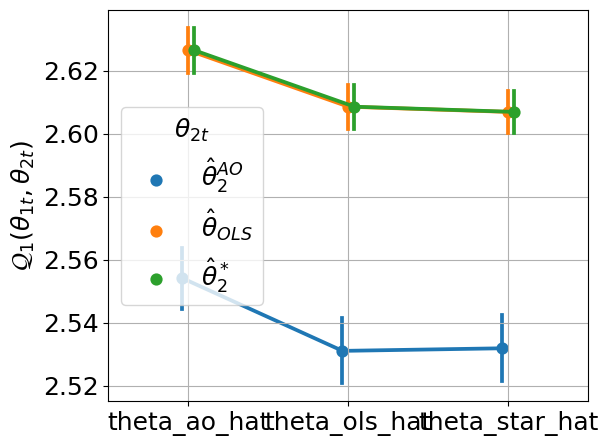

In [45]:
fig,ax=plt.subplots() 
plot_obj = sns.pointplot(df_, y='perf_env0', x='test_theta_env0', hue=r'$\theta_{2t}$', ax=ax, dodge=True, errorbar='se')
ax.grid () 

ax.set_ylabel(r'$\mathcal{Q}_1(\theta_{1t}, \theta_{2t})$')
ax.set_xlabel('')
# ax.set_xticklabels([r'$\theta_{1t} = \hat{\theta}^{AO}_1$', r'$\theta_{1t} = \hat{\theta}^*_1$'])

plt.tight_layout() 
plt.savefig('figures/utility-multi-env.pdf')

In [87]:
df_test = df_.groupby([r'$\theta_{2t}$', 'test_theta_env0' ]).agg(['mean', 'sem'])
df_test 

perf_env0          
                                           mean       sem
$\theta_{2t}$         test_theta_env0                    
$\hat{\theta}^{AO}_2$ theta_ao_hat     2.550188  0.008291
                      theta_ols_hat    2.525459  0.008290
                      theta_star_hat   2.525889  0.008421
$\hat{\theta}_{OLS}$  theta_ao_hat     2.613778  0.005802
                      theta_ols_hat    2.592918  0.006307
                      theta_star_hat   2.593095  0.006209
$\hat{\theta}^*_2$    theta_ao_hat     2.613778  0.005802
                      theta_ols_hat    2.592918  0.006307
                      theta_star_hat   2.593095  0.006209

In [29]:
# with open('temp.pkl', 'wb') as f:
    # pickle.dump(df_test, f)
with open('temp.pkl', 'rb') as f:
    df_test_ref = pickle.load(f)
df_test_ref == df_test 